In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_z
from numba import njit

In [8]:
ξ_1m = 1000.
ξ_a = 1000.

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
# σ_y = 1.2*1.86/1000
σ_y = 0.

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
# γ_2p = .0197*2*.5 # weighted model of low and high
γ_2p = 0. # low damage model

n_y = 50
y_min = 0.
y_max = 4.
y_grid = np.linspace(y_min, y_max, n_y)

model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p, y_bar) 
model_res = ode_y(y_grid, model_paras, v0=None, ϵ=.5,
                                  tol=1e-8, max_iter=5_000, print_all=False)

Converged. Total iteration 2024: LHS Error: 9.986334051359513e-09; RHS Error 4.4193490324669635e-06


In [11]:
def simulation(y_grid, e_grid, θ=1.86/1000., y_start=.5394, T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt

(0.0, 18.0)

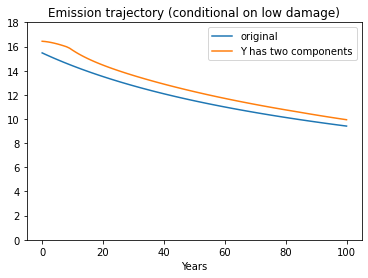

In [22]:
et, _ = simulation(y_grid, model_res['e_tilde'])
et_two_state = np.load('et_two_state.npy')
plt.plot(et, label = 'original')
plt.plot(et_two_state, label = 'Y has two components')
plt.legend()
plt.title('Emission trajectory (conditional on low damage)')
plt.xlabel('Years')
plt.ylim(0, 18)

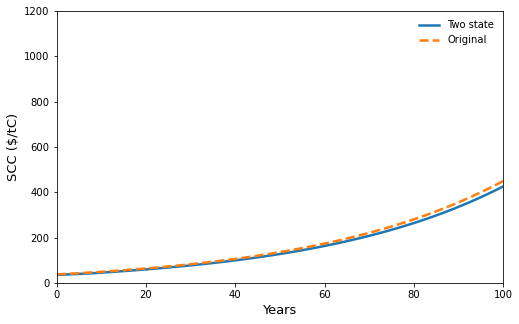

In [24]:
# 5. Plot SCC
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

SCCt_two_state = η*(0.025)*Kt/((1.-η)*et_two_state) * 1000
SCCt = η*(0.025)*Kt/((1.-η)*et) * 1000



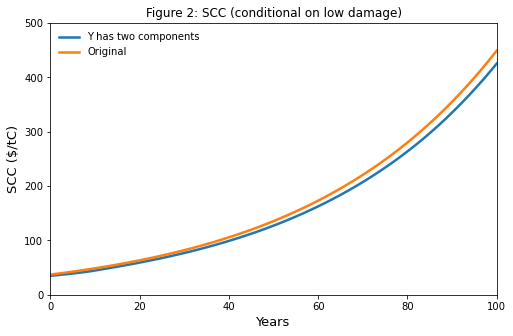

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(SCCt_two_state, label='Y has two components', linewidth=2.5)
plt.plot(SCCt, label='Original', linewidth=2.5)

plt.ylim(0, 500)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False)
plt.title('Figure 2: SCC (conditional on low damage)')
plt.savefig('../plots/fig_2.pdf')

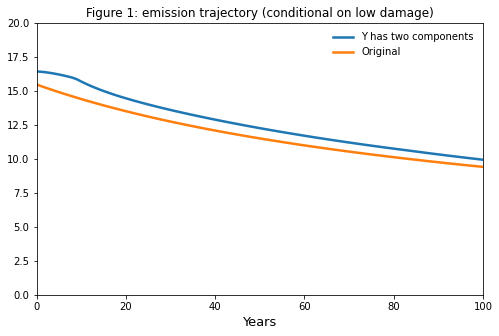

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(et_two_state, label='Y has two components', linewidth=2.5)
plt.plot(et, label='Original', linewidth=2.5)

plt.ylim(0, 20)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
# plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False)
plt.title('Figure 1: emission trajectory (conditional on low damage)')
plt.savefig('../plots/fig_1.pdf')